# Table of Contents:

* **Project Overview.**
* **Importing Libraries.**<br><br>
* **1. Features Exploration:**
  * 1.1 Datasets Features.<br>
  * 1.2 Features Types.<br>
  * 1.3 Features Visualization.<br>
* **2. Features Engineering:**
  * 2.1 Missing Values.<br>
  * 2.2 Features Engineering.<br>
* **3. Model Creation:**
  * 3.1 Determine Hyperparameters.<br>
  * 3.2 Algorithm Fitting.<br>
  * 3.3 Create Submission File.<br>

---

## Project Overview:

Imagine being hungry in an unfamiliar part of town and getting restaurant recommendations served up, based on your personal preferences, at just the right moment. The recommendation comes with an attached discount from your credit card provider for a local place around the corner!

Right now, Elo, one of the largest payment brands in Brazil, has built partnerships with merchants in order to offer promotions or discounts to cardholders. But do these promotions work for either the consumer or the merchant? Do customers enjoy their experience? Do merchants see repeat business? Personalization is key.

Elo has built machine learning models to understand the most important aspects and preferences in their customers’ lifecycle, from food to shopping. But so far none of them is specifically tailored for an individual or profile. This is where you come in.

In this competition, Kagglers will develop algorithms to identify and serve the most relevant opportunities to individuals, by uncovering signal in customer loyalty. Your input will improve customers’ lives and help Elo reduce unwanted campaigns, to create the right experience for customers.

---

## Importing Libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

---

# 1. Features Exploration

In [2]:
# Import needed datasets
train = pd.read_csv('train.csv', parse_dates=['first_active_month'])
test = pd.read_csv('test.csv', parse_dates=['first_active_month'])
historical_transactions = pd.read_csv('historical_transactions.csv', parse_dates=['purchase_date'])
new_merchant_transactions = pd.read_csv('new_merchant_transactions.csv', parse_dates=['purchase_date'])
merchants = pd.read_csv('merchants.csv')

## 1.1 Datasets Features:

**train**:<br>
card_id: Unique card identifier<br>
first_active_month: 'YYYY-MM', month of first purchase<br>
feature_1: Anonymized card categorical feature<br>
feature_2: Anonymized card categorical feature<br>
feature_3: Anonymized card categorical feature<br>
target: Loyalty numerical score calculated 2 months after historical and evaluation period<br><br>

**historical_transactions & new_merchant_transactions**:<br>
card_id: Card identifier<br>
month_lag: month lag to reference date<br>
purchase_date: Purchase date<br>
authorized_flag: Y'if approved, 'N' if denied<br>
category_3: anonymized category<br>
installments: number of installments of purchase<br>
category_1: anonymized category<br>
merchant_category_id: Merchant category identifier (anonymized )<br>
subsector_id: Merchant category group identifier (anonymized )<br>
merchant_id: Merchant identifier (anonymized)<br>
purchase_amount: Normalized purchase amount<br>
city_id	City: identifier (anonymized )<br>
state_id: State identifier (anonymized )<br>
category_2: anonymized category<br><br>

**merchants**:<br>
merchant_id: Unique merchant identifier<br>
merchant_group_id: Merchant group (anonymized )<br>
merchant_category_id: Unique identifier for merchant category (anonymized )<br>
subsector_id: Merchant category group (anonymized )<br>
numerical_1: anonymized measure<br>
numerical_2: anonymized measure<br>
category_1: anonymized category<br>
most_recent_sales_range: Range of revenue (monetary units) in last active month --> A > B > C > D > E<br>
most_recent_purchases_range: Range of quantity of transactions in last active month --> A > B > C > D > E<br>
avg_sales_lag3: Monthly average of revenue in last 3 months divided by revenue in last active month<br>
avg_purchases_lag3: Monthly average of transactions in last 3 months divided by transactions in last active month<br>
active_months_lag3: Quantity of active months within last 3 months<br>
avg_sales_lag6: Monthly average of revenue in last 6 months divided by revenue in last active month<br>
avg_purchases_lag6: Monthly average of transactions in last 6 months divided by transactions in last active month<br>
active_months_lag6: Quantity of active months within last 6 months<br>
avg_sales_lag12: Monthly average of revenue in last 12 months divided by revenue in last active month<br>
avg_purchases_lag12: Monthly average of transactions in last 12 months divided by transactions in last active month<br>
active_months_lag12: Quantity of active months within last 12 months<br>
category_4: anonymized category<br>
city_id	City: identifier (anonymized )<br>
state_id: State identifier (anonymized )<br>
category_2: anonymized category

---

## 1.2 Features Types

#### First off, let's have a look on the features types:

In [3]:
# Check features types
for df in [train, test, historical_transactions, new_merchant_transactions, merchants]:
    display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
first_active_month    201917 non-null datetime64[ns]
card_id               201917 non-null object
feature_1             201917 non-null int64
feature_2             201917 non-null int64
feature_3             201917 non-null int64
target                201917 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 9.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123623 entries, 0 to 123622
Data columns (total 5 columns):
first_active_month    123622 non-null datetime64[ns]
card_id               123623 non-null object
feature_1             123623 non-null int64
feature_2             123623 non-null int64
feature_3             123623 non-null int64
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 4.7+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29112361 entries, 0 to 29112360
Data columns (total 14 columns):
authorized_flag         object
card_id                 object
city_id                 int64
category_1              object
installments            int64
category_3              object
merchant_category_id    int64
merchant_id             object
month_lag               int64
purchase_amount         float64
purchase_date           datetime64[ns]
category_2              float64
state_id                int64
subsector_id            int64
dtypes: datetime64[ns](1), float64(2), int64(6), object(5)
memory usage: 3.0+ GB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1963031 entries, 0 to 1963030
Data columns (total 14 columns):
authorized_flag         object
card_id                 object
city_id                 int64
category_1              object
installments            int64
category_3              object
merchant_category_id    int64
merchant_id             object
month_lag               int64
purchase_amount         float64
purchase_date           datetime64[ns]
category_2              float64
state_id                int64
subsector_id            int64
dtypes: datetime64[ns](1), float64(2), int64(6), object(5)
memory usage: 209.7+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334696 entries, 0 to 334695
Data columns (total 22 columns):
merchant_id                    334696 non-null object
merchant_group_id              334696 non-null int64
merchant_category_id           334696 non-null int64
subsector_id                   334696 non-null int64
numerical_1                    334696 non-null float64
numerical_2                    334696 non-null float64
category_1                     334696 non-null object
most_recent_sales_range        334696 non-null object
most_recent_purchases_range    334696 non-null object
avg_sales_lag3                 334683 non-null float64
avg_purchases_lag3             334696 non-null float64
active_months_lag3             334696 non-null int64
avg_sales_lag6                 334683 non-null float64
avg_purchases_lag6             334696 non-null float64
active_months_lag6             334696 non-null int64
avg_sales_lag12                334683 non-null float64
avg_purchases_lag12    

None

---

## 1.3 Features Visualization

#### Before engineering the features, let's have a visual look on how different features contribute in the determination of our dependent variable 'target'

#### We need first to merge the train dataset with the rest of the datasets 

In [4]:
# Add 'card_id' to 'merchants' dataset to facilitate the merging
joined_dfs = pd.concat([historical_transactions[['card_id', 'merchant_id']], new_merchant_transactions[['card_id', 'merchant_id']]])
merchants = pd.merge(joined_dfs, merchants, on='merchant_id')

# Merge all datasets with 'train' to check the how the different features are reacting with 'target'
hist_df = pd.merge(train, historical_transactions, on='card_id', how='left')
new_df = pd.merge(train, new_merchant_transactions, on='card_id', how='left')
mer_df = pd.merge(train, merchants, on='card_id', how='left')

# Set the sizes of different graphs
plt.rcParams['figure.figsize'] = 16, 4

#### It will be tempting to start with the distribution of our dependent variable 'target'

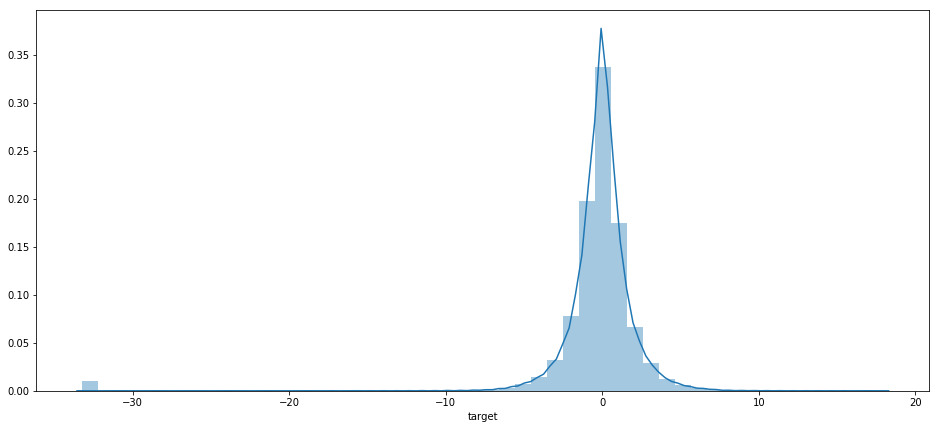

In [5]:
# 'target' feture histogram
plt.rcParams['figure.figsize'] = 16, 7
a = sns.distplot(train['target'])

#### The values are symmetrically distributed, except some noticeable ourliers on the far left (below -30)

#### Another important feature we might want to have a look on is 'first_active_month'

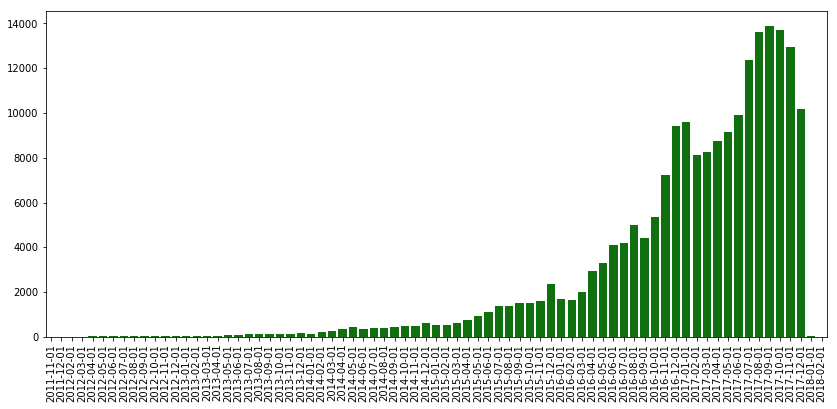

In [6]:
# 'first_active_month' histogram (inspired by Sudalairaj Kumar's kernel: "https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-elo")
dates = train['first_active_month'].dt.date.value_counts()
dates = dates.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(dates.index, dates.values, color='green')
plt.xticks(rotation='vertical')
plt.show()

#### The number of cards activated for the first time is increasing by time. This can gives us an insight to the importance of this feature and how we can break it down to increase the accuracy of our prediction  

#### After that, we can have a visual check on how different features' classes correlate with 'target'

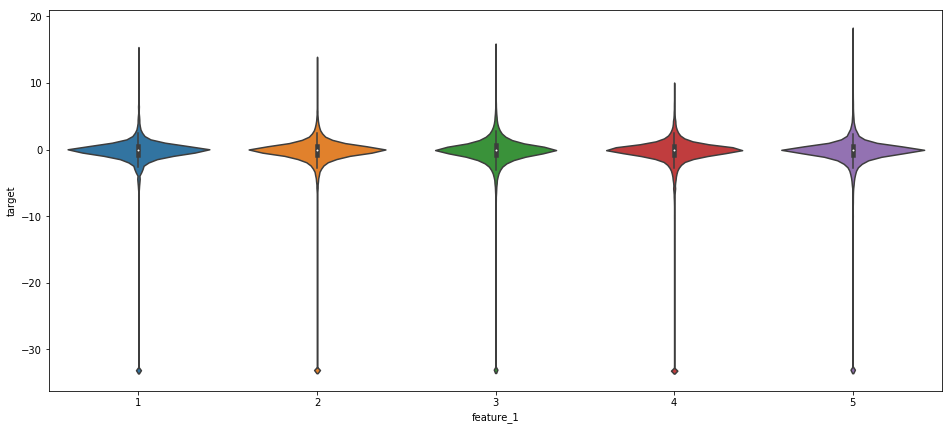

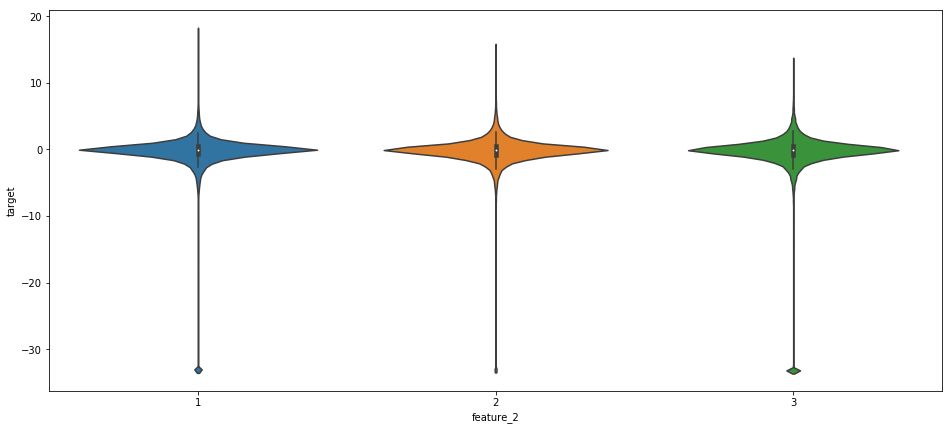

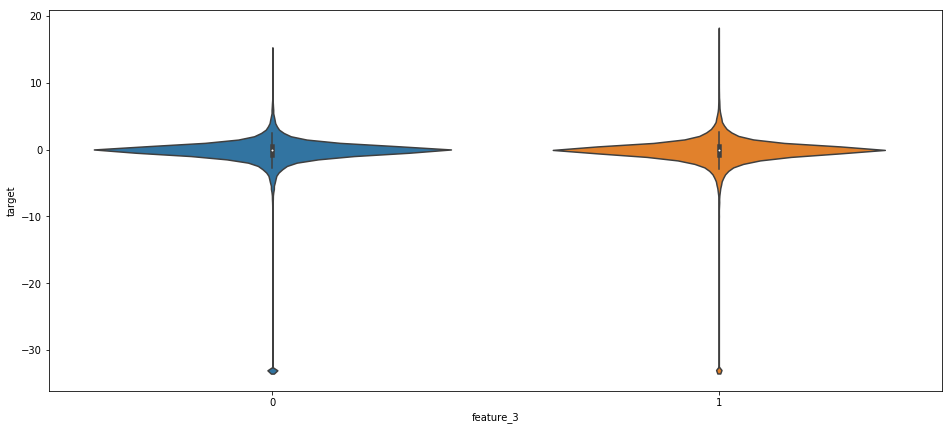

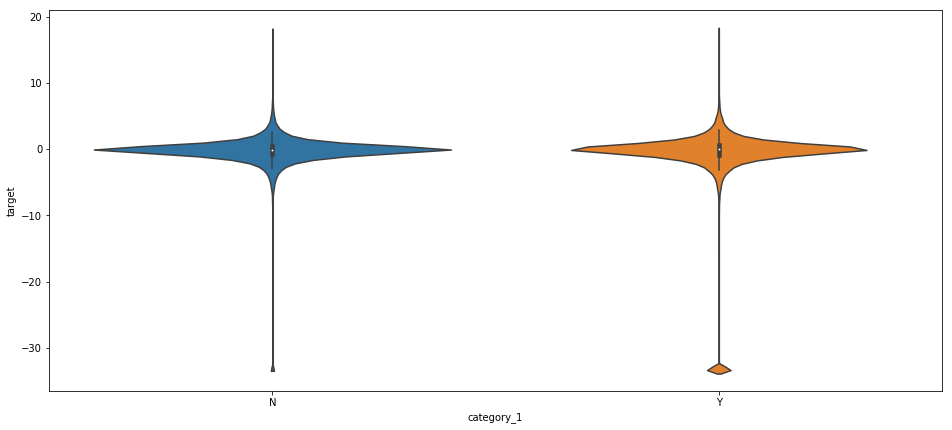

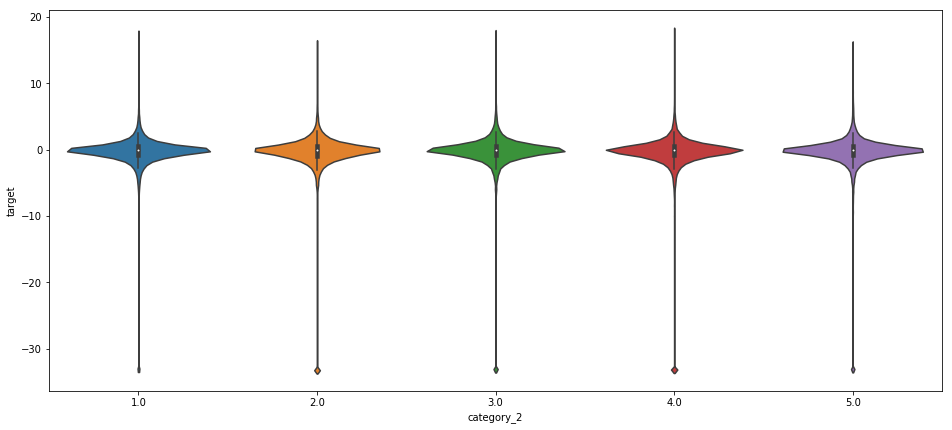

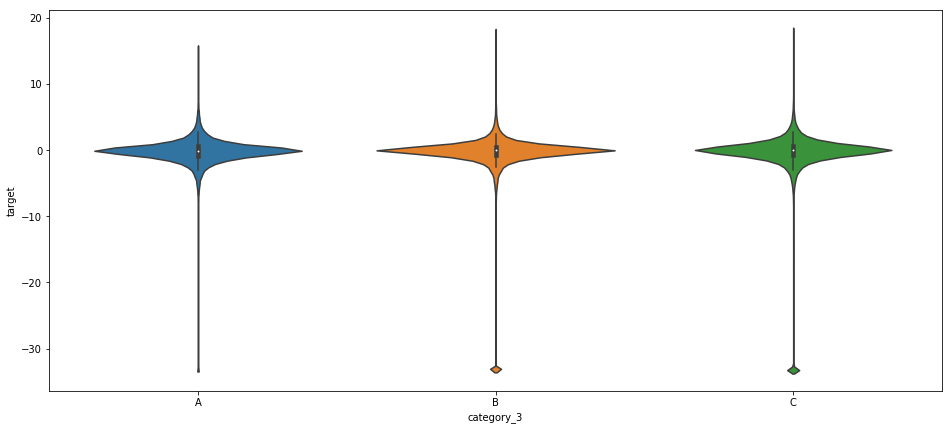

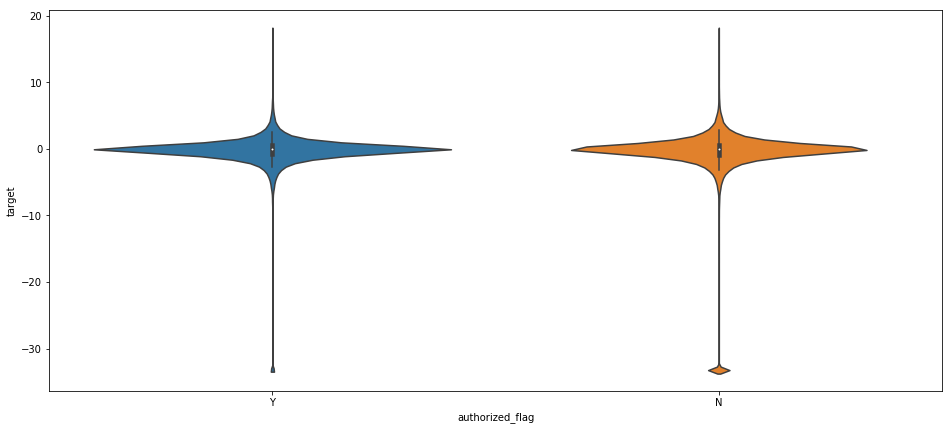

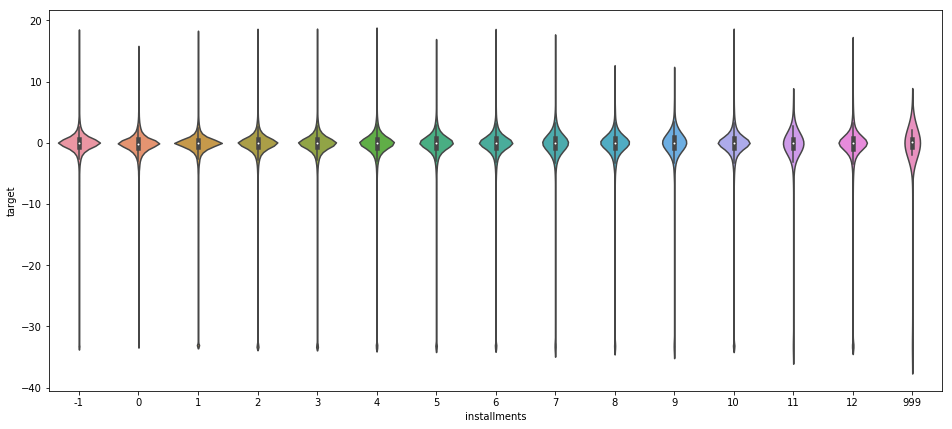

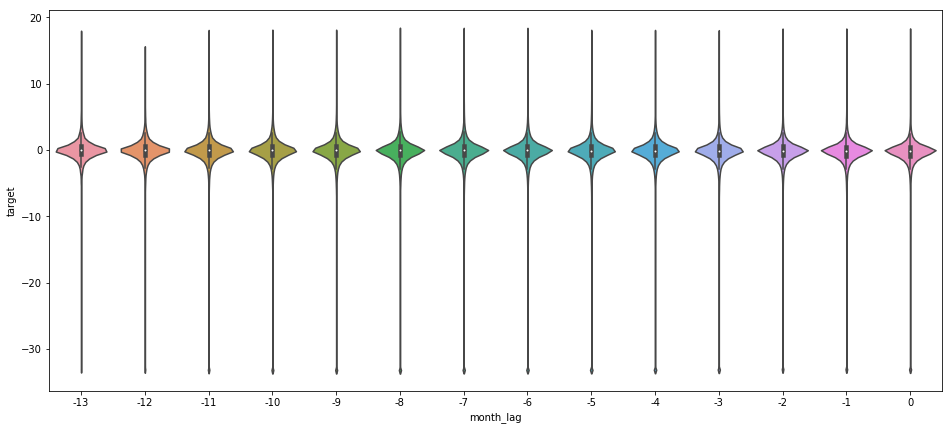

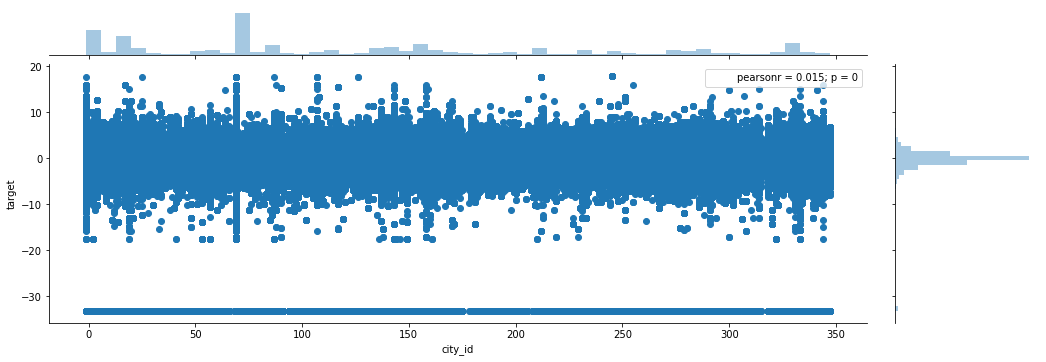

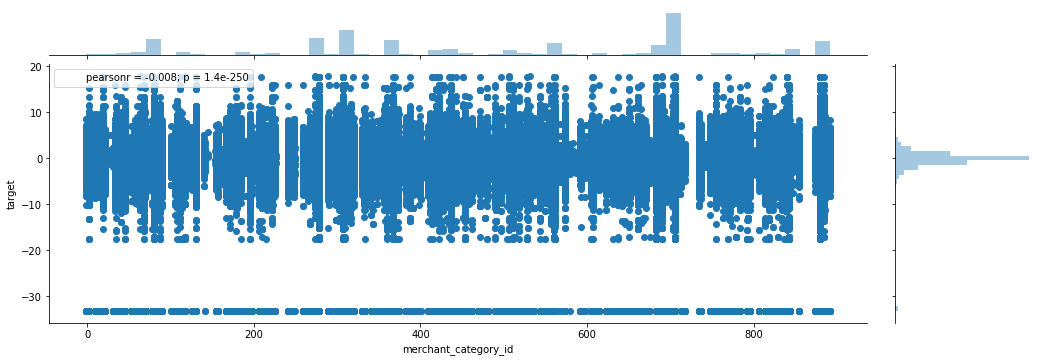

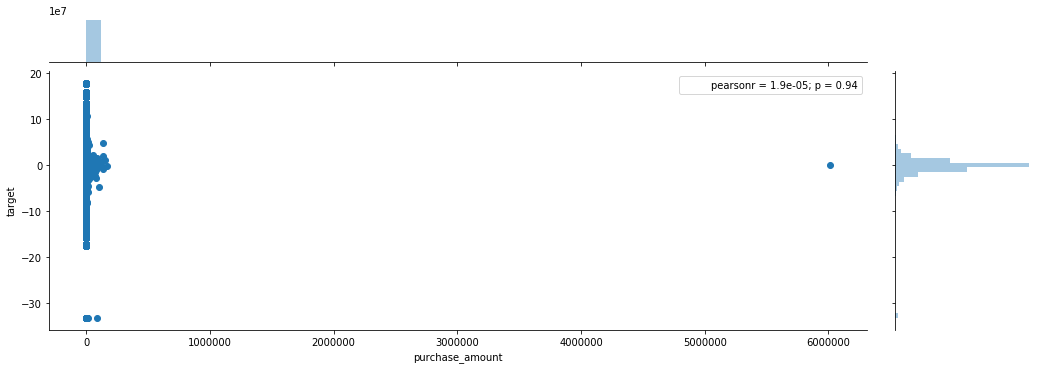

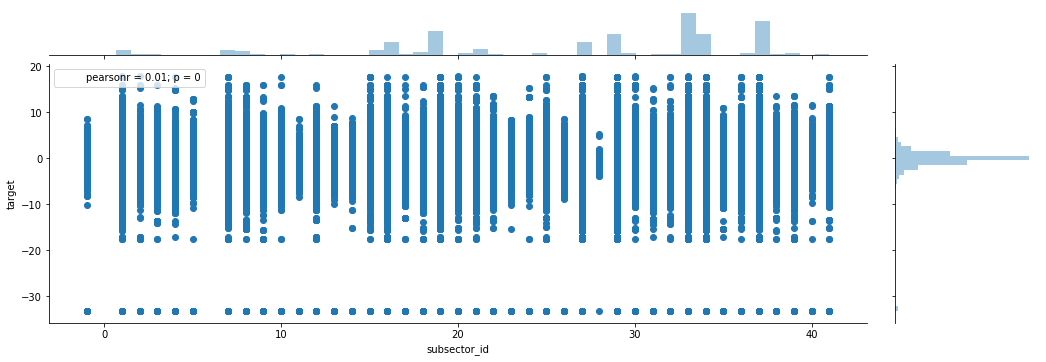

In [7]:
# Create a new dataset
df = hist_df

# Object that holds discrete features in the above dataset
discrete = ['feature_1', 'feature_2', 'feature_3', 'category_1', 'category_2', 'category_3', 'authorized_flag',
          'installments', 'month_lag']

# Object that holds continuous features in the above dataset
continuous = ['city_id', 'merchant_category_id', 'purchase_amount', 'subsector_id']

# Loop through discrete features and use violin plot to visualize each feature
for column in discrete:
    a1 = sns.violinplot(df[column], df['target'])
    plt.show()

# Loop through continuous features and use violin plot to visualize each feature
for column in continuous:
    j = sns.jointplot(data=df, x = column, y='target')
    j.fig.set_figwidth(16)
    j.fig.set_figheight(5)

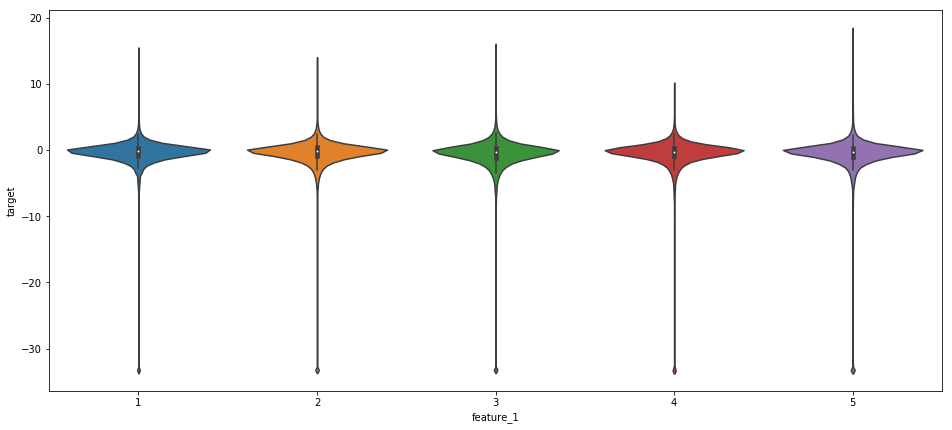

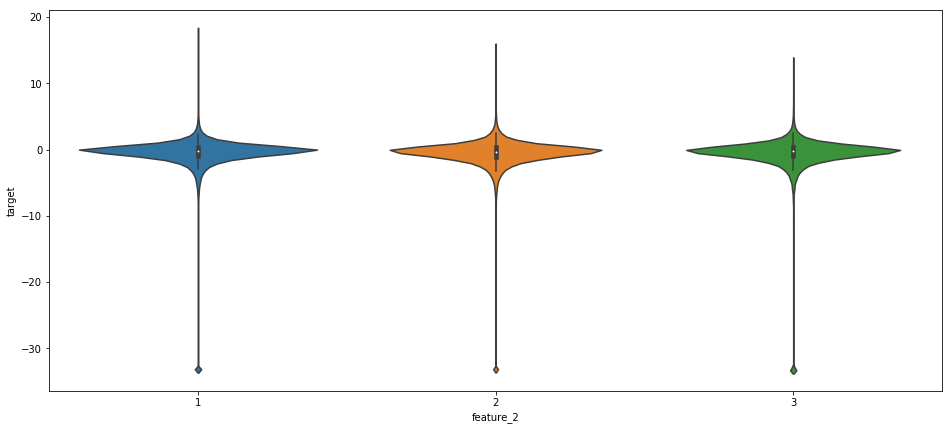

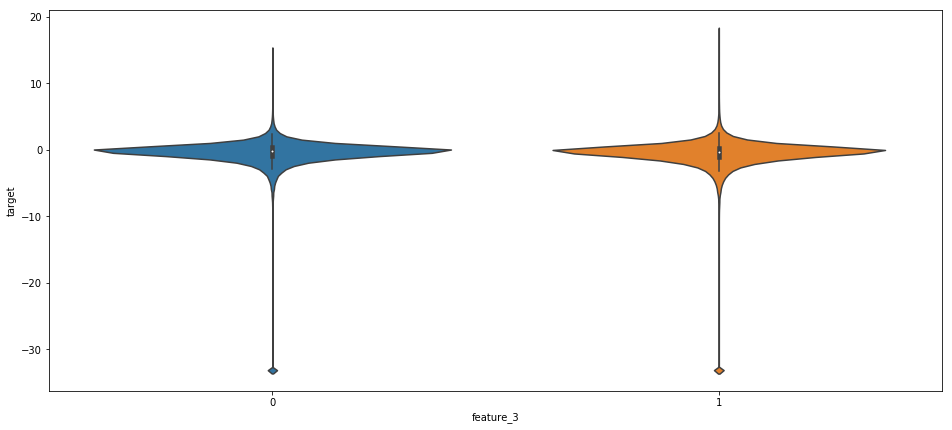

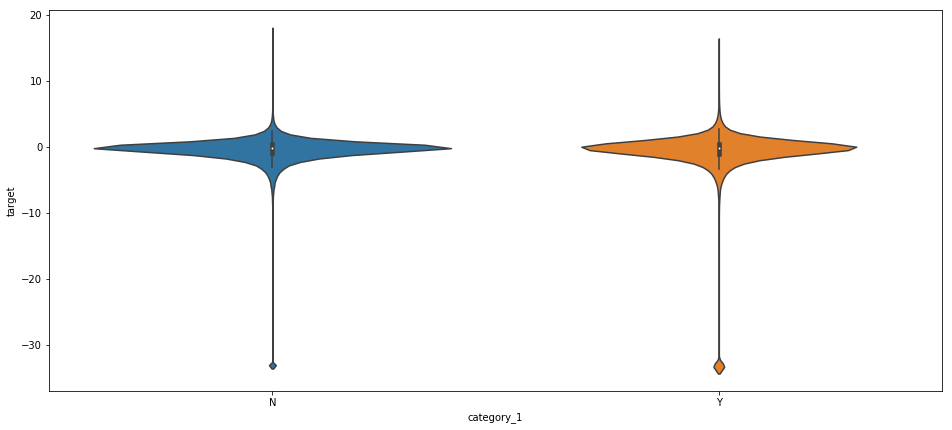

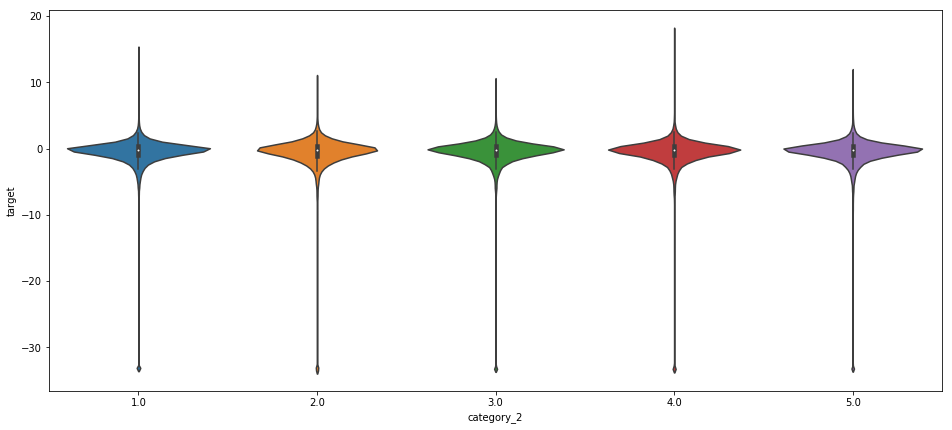

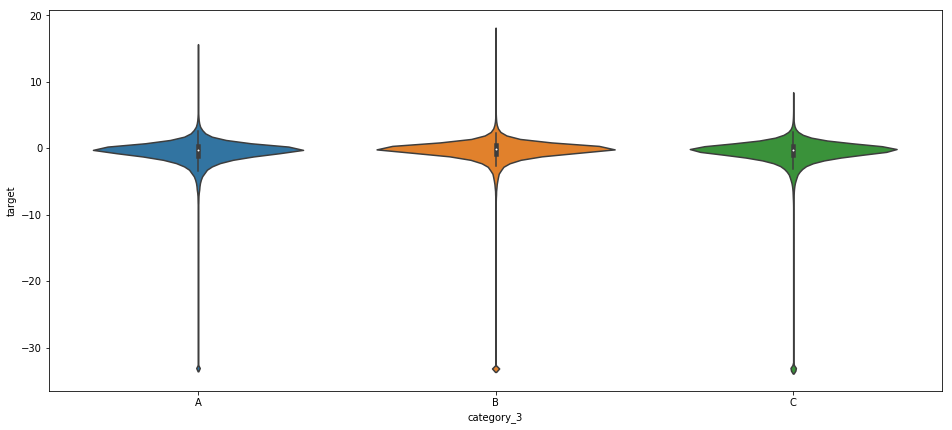

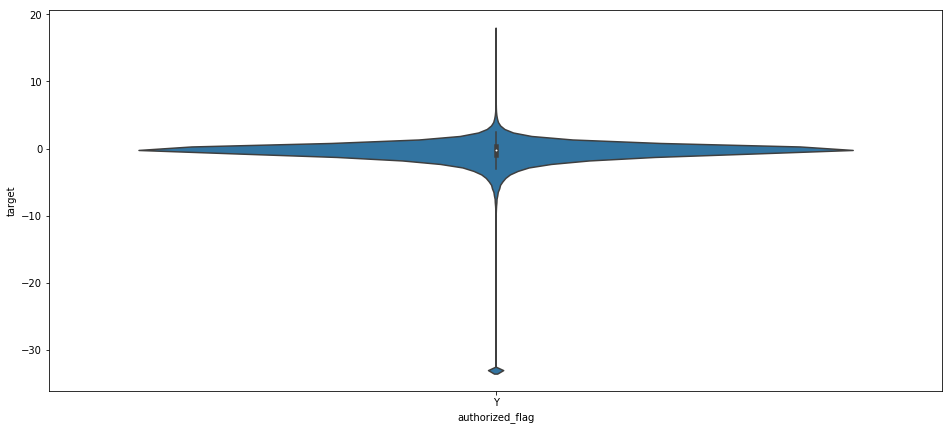

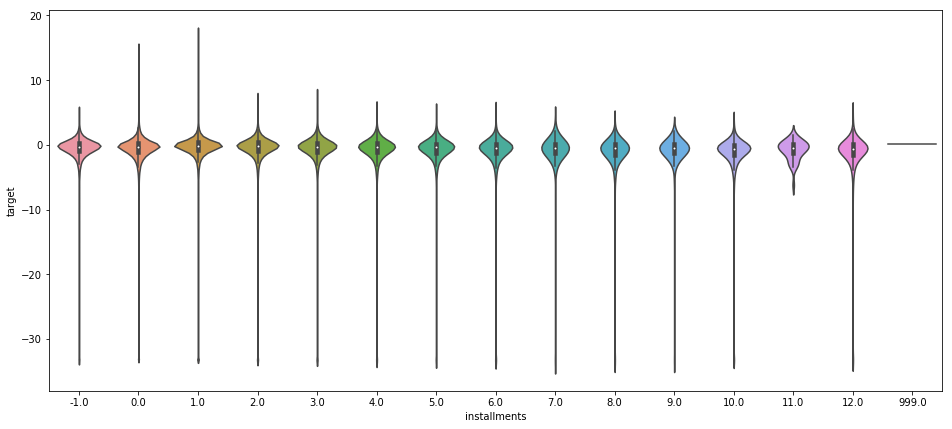

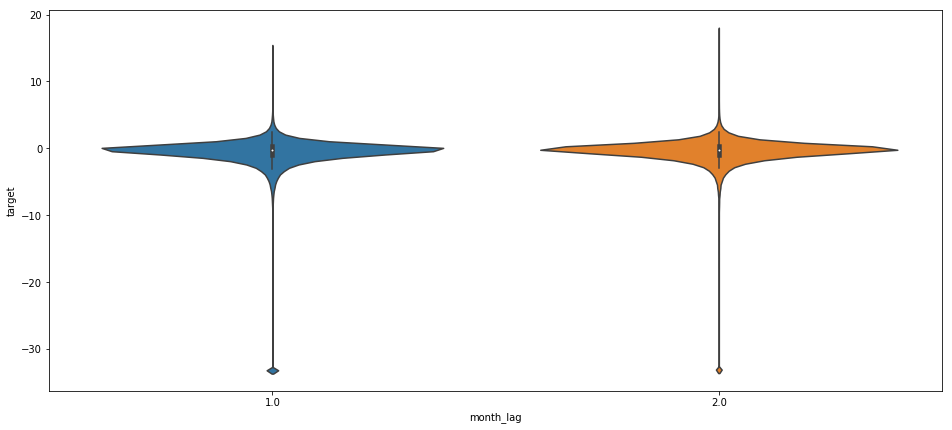

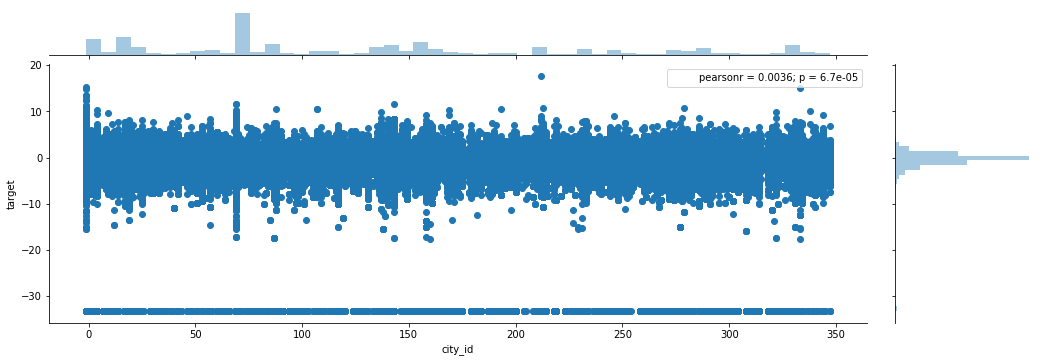

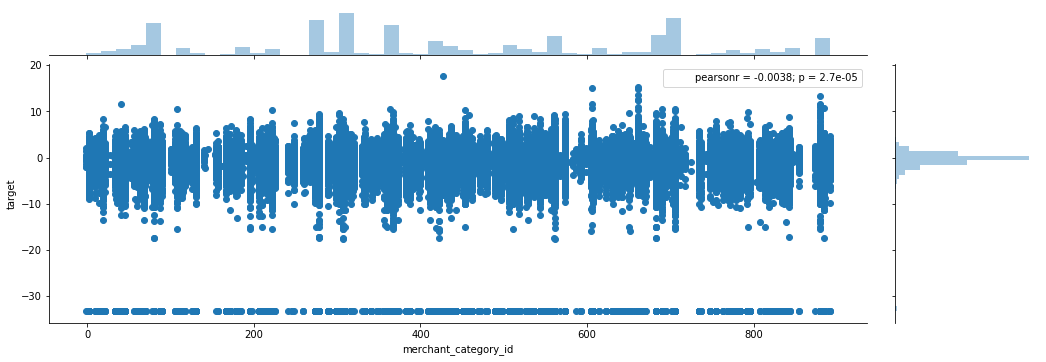

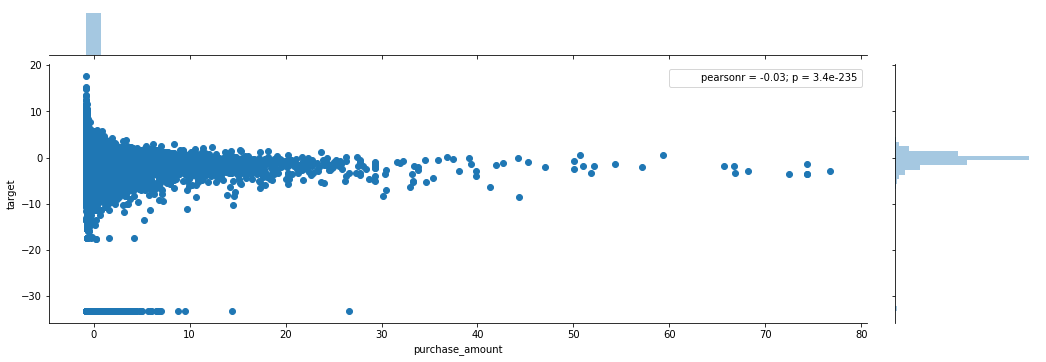

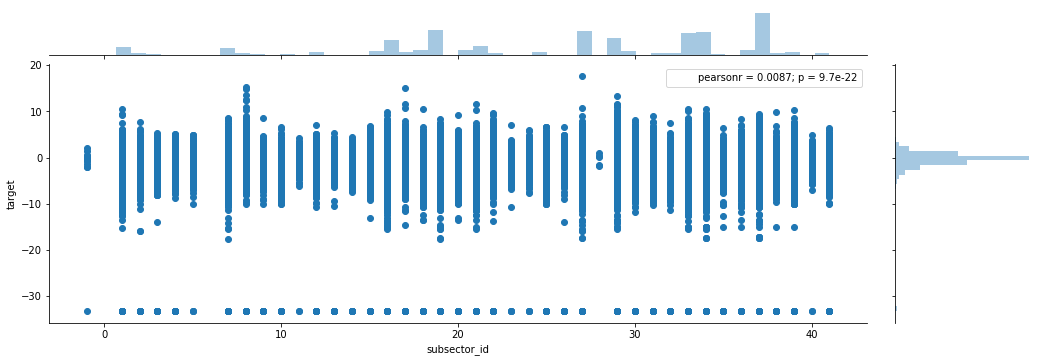

In [8]:
# Create a new dataset
df = new_df

# Object that holds discrete features in the above dataset
discrete = ['feature_1', 'feature_2', 'feature_3', 'category_1', 'category_2', 'category_3', 'authorized_flag',
          'installments', 'month_lag']

# Object that holds continuous features in the above dataset
continuous = ['city_id', 'merchant_category_id', 'purchase_amount', 'subsector_id']

# Loop through discrete features and use violin plot to visualize each feature
for column in discrete:
    a1 = sns.violinplot(df[column], df['target'])
    plt.show()

# Loop through continuous features and use violin plot to visualize each feature
for column in continuous:
    j = sns.jointplot(data=df, x = column, y='target')
    j.fig.set_figwidth(16)
    j.fig.set_figheight(5)

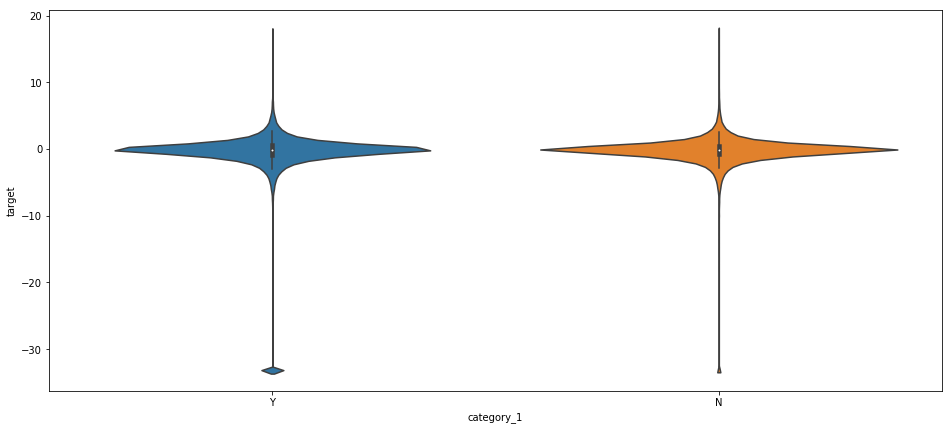

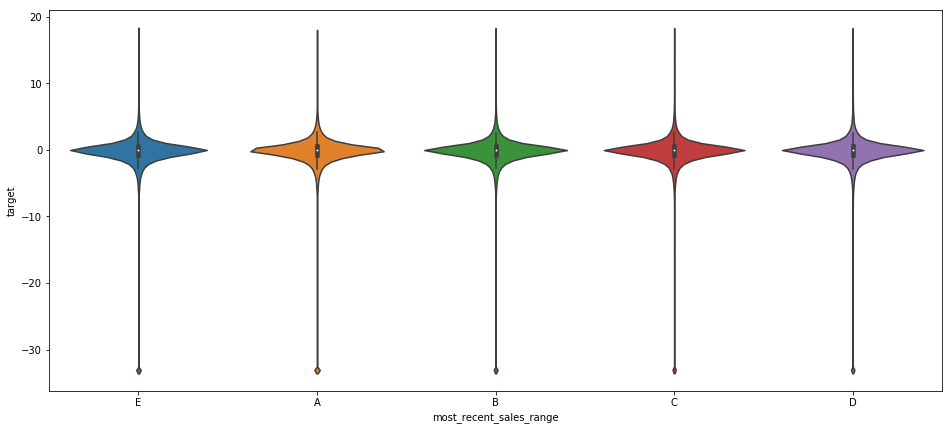

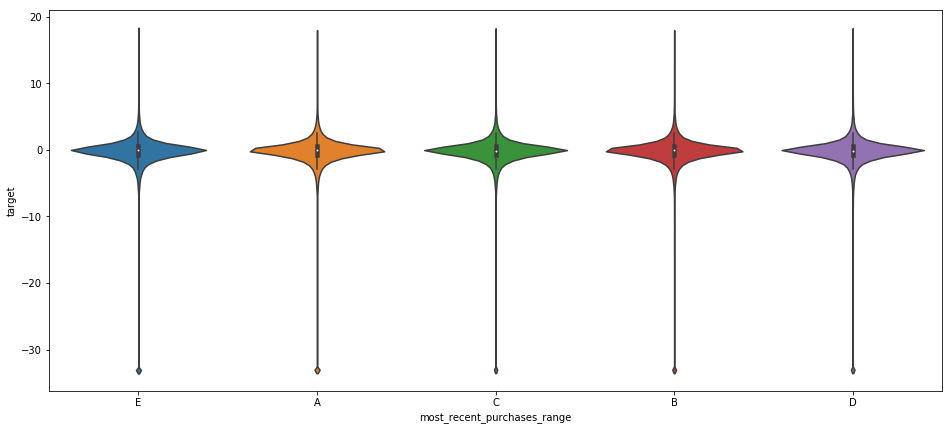

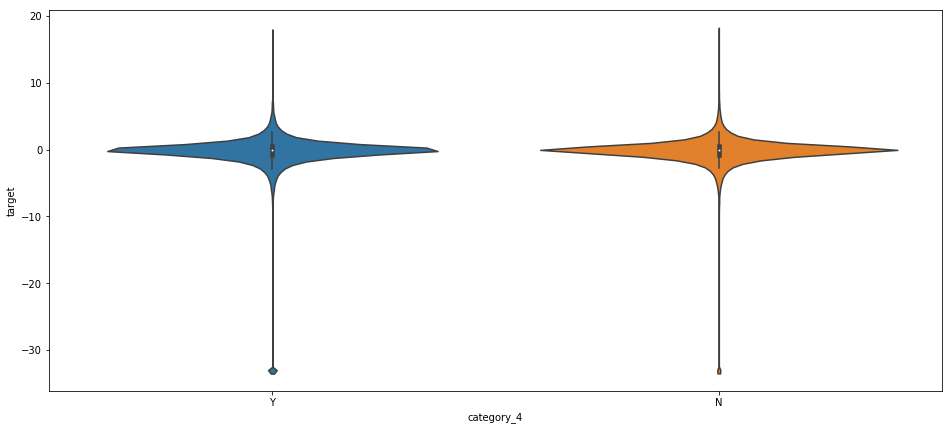

In [9]:
# Create a new dataset
df = mer_df

# Object that holds discrete features in the above dataset
discrete = ['category_1', 'most_recent_sales_range', 'most_recent_purchases_range', 'category_4']

# Loop through discrete features and use violin plot to visualize each feature
for column in discrete:
    a1 = sns.violinplot(df[column], df['target'])
    plt.show()

#### According to the above graphs, we can't see a noticeable difference among each feature's classes in terms of the distribution of the class against 'target'. Only 'purchase_amount' can be considered as an important feature in the determination of 'target'

---

# 2. Features Engineering

## 2.1 Missing Values

#### Maybe if features have been aggregate the prediction of 'target' can become more accurate. Let's first check if there are any missing values and also see how to optimize the features for a better prediction

In [10]:
# Create a list that holds all dataset
dfs = [train, test, historical_transactions, new_merchant_transactions, merchants]

# Create a title list with the name of each dataset 
dfs_titles = ['train', 'test', 'historical_transactions', 'new_merchant_transactions', 'merchants']
counter = 0

# Loop on each dataset to check the missing values within it
for df in dfs:
    print('\nDisplay the number of missing observations within "%s" dataset' % dfs_titles[counter])
    display(df.isnull().sum().reset_index(name='count').sort_values(by='count', ascending=False))
    counter += 1



Display the number of missing observations within "train" dataset


,index,count
0,first_active_month,0
1,card_id,0
2,feature_1,0
3,feature_2,0
4,feature_3,0
5,target,0



Display the number of missing observations within "test" dataset


,index,count
0,first_active_month,1
1,card_id,0
2,feature_1,0
3,feature_2,0
4,feature_3,0



Display the number of missing observations within "historical_transactions" dataset


,index,count
11,category_2,2652864
5,category_3,178159
7,merchant_id,138481
0,authorized_flag,0
1,card_id,0
2,city_id,0
3,category_1,0
4,installments,0
6,merchant_category_id,0
8,month_lag,0



Display the number of missing observations within "new_merchant_transactions" dataset


,index,count
11,category_2,111745
5,category_3,55922
7,merchant_id,26216
0,authorized_flag,0
1,card_id,0
2,city_id,0
3,category_1,0
4,installments,0
6,merchant_category_id,0
8,month_lag,0



Display the number of missing observations within "merchants" dataset


,index,count
22,category_2,5769283
16,avg_sales_lag12,9401
10,avg_sales_lag3,9401
13,avg_sales_lag6,9401
12,active_months_lag3,0
21,state_id,0
20,city_id,0
19,category_4,0
18,active_months_lag12,0
17,avg_purchases_lag12,0


#### By having a look on the above tables, we can notice that:<br>
1- train and test has 'first_active_month' which we can break down to other different features like (year, month, week of year, day of week and weekend).<br>
2- In historical and new merchants datasets, features like (first_active_month, category_1, category_3) can be converted to numericals, as well as 'purchase_date' which can have the same break down as train and test datasets, and eventually, delete features ('category_2' and 'category_3') due to the large number of missing values.<br>
3- In merchants, features (category_1, most_recent_sales_range, most_recent_purchases_range, category_4) can also be converted to become numericals, features (avg_sales_lag3, avg_sales_lag6, avg_sales_lag12) can be completed with their median, and 'category_2' will be removed.

---

## 2.2 Features Engineering

#### Following further, let's start with the breakdown and conversion of the different features:

In [11]:
# Calculate the time difference between the reference date (2018, 2, 1) and first active month feature (Peter Hurford's kernel: "https://www.kaggle.com/peterhurford/you-re-going-to-want-more-categories-lb-3-737")
train['elapsed_time'] = (datetime.date(2018, 2, 1) - train['first_active_month'].dt.date).dt.days
test['elapsed_time'] = (datetime.date(2018, 2, 1) - test['first_active_month'].dt.date).dt.days

# Break down the date feature & delete the 'first_active_month' feature (Chau Huynh's kernel: "https://www.kaggle.com/chauhuynh/my-first-kernel-3-699")
for df in [train, test]:
    df["first_year"] = df["first_active_month"].dt.year
    df["first_month"] = df["first_active_month"].dt.month
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekend'] = (df.first_active_month.dt.weekday >=5).astype(int)
    df['first_year'] = df['first_year'].fillna(df['first_year'].median())
    df['first_month'] = df['first_month'].fillna(df['first_month'].median())
    df.drop(['first_active_month'], axis=1, inplace=True)

# Omitting observations with missing 'merchant_id'
historical_transactions = historical_transactions[historical_transactions['merchant_id'].notnull()]
new_merchant_transactions = new_merchant_transactions[new_merchant_transactions['merchant_id'].notnull()]

# Convert categorical features to quantitative
for df in [historical_transactions, new_merchant_transactions]:
    for column in ['authorized_flag', 'category_1']:
        df[column] = df[column].map({'Y':1, 'N':0})

# Break down the date feature & delete the unneeded features
for df in [historical_transactions, new_merchant_transactions]:
    df['purchase_year'] = df["purchase_date"].dt.year
    df["purchase_month"] = df["purchase_date"].dt.month
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df.drop(['purchase_date', 'category_2', 'category_3'], axis=1, inplace=True)

# Convert categorical features to quantitative
for df in [merchants]:
    for column in ['category_1', 'category_4']:
        df[column] = df[column].map({'Y':1, 'N':0})
    for column in ['most_recent_sales_range', 'most_recent_purchases_range']:
        df[column] = df[column].map({'A':1, 'B':0, 'C':3, 'D':4, 'E':5})
    
# Replace missing values with median
for column in ['avg_sales_lag3', 'avg_sales_lag6', 'avg_sales_lag12']:
        merchants[column] = merchants[column].fillna(merchants[column].median())
        
# Delete 'category_2' feature
merchants.drop(['category_2'], axis=1, inplace=True)

#### Time now to aggregate the features. Here, i chose to aggregate all columns to get the maximum accuracy

In [12]:
# Aggregate all 'historical_transactions' dataset's features
agg_func = {}
for column in historical_transactions.columns:
    if column not in  ('card_id', 'merchant_id'):
        agg_func[column] = ['min', 'max', 'sum', 'nunique', 'count', 'mean', 'median', 'std']
    if column in  ('card_id'):
        agg_func[column] = ['size']
historical_transactions = historical_transactions.groupby(by='card_id').agg(agg_func)

# Aggregate all 'new_merchant_transactions' dataset's features
agg_func = {}
for column in new_merchant_transactions.columns:
    if column not in  ('card_id', 'merchant_id'):
        agg_func[column] = ['min', 'max', 'sum', 'nunique', 'count', 'mean', 'median', 'std']
    if column in  ('card_id'):
        agg_func[column] = ['size']
new_merchant_transactions = new_merchant_transactions.groupby(by='card_id').agg(agg_func)

# Aggregate all 'merchants' dataset's features
agg_func = {}
for column in merchants.columns:
    if column not in ('card_id', 'merchant_id'):
        agg_func[column] = ['min', 'max', 'sum', 'nunique', 'count', 'mean', 'median', 'std']
    if column in  ('card_id'):
        agg_func[column] = ['size']
    if column in ('merchant_id'):
        agg_func[column] = ['count']
merchants = merchants.groupby(by='card_id').agg(agg_func)

# Convert columns from two levels (after the aggregation, features were displayed as two levels) to one level
for df in [historical_transactions, new_merchant_transactions, merchants]:
    df.columns = ['_'.join(col).strip() for col in df.columns.values]
    df['card_id'] = df.index
    
# Distinguish datasets' features with different features' names with an indication to which feature belongs to which dataset
counter = 0
abr = ['his', 'new', 'mer']
for df in [historical_transactions, new_merchant_transactions, merchants]:
    df.columns = abr[counter] + '_' + df.columns
    df.rename(columns={df.columns[-1]: 'card_id'}, inplace=True)
    counter += 1

#### Moreover, we need to merge datasets togather to fit the algorithm to it

In [13]:
# Merge different datasets with 'train'
new_train = pd.merge(train, historical_transactions, on='card_id')
new_train = pd.merge(new_train, new_merchant_transactions, on='card_id', how='left')
new_train = pd.merge(new_train, merchants, on='card_id')
new_train = new_train.set_index('card_id')

# Merge different datasets with 'test'
new_test = pd.merge(test, historical_transactions, on='card_id')
new_test = pd.merge(new_test, new_merchant_transactions, on='card_id', how='left')
new_test = pd.merge(new_test, merchants, on='card_id')
new_test = new_test.set_index('card_id')

# Create a correlation dataframe between 'target' and all features
corr = abs(new_train.corr().target).sort_values(ascending=False).reset_index()

# Create a new_train dataset with all features that has a correlation with 'target' and neglect those with 'NAN'
new_train = new_train[corr[corr['target'].notna()]['index']]

# Create a new_test dataset with all features that has a correlation with 'target' and neglect those with 'NAN'
new_test = new_test[corr[corr['target'].notna()]['index'][1:]]

#### Just to make sure that features engineering will do a good job in the prediction, let's have a look over a sample of a couple of features after the aggregation and see how their relationship with 'target' is like:

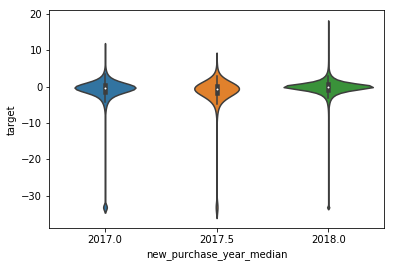

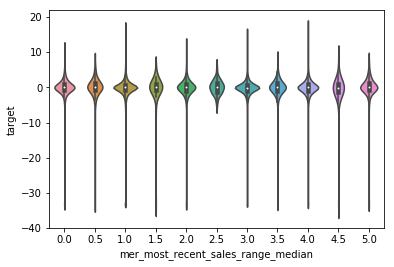

In [14]:
# Create a copy of new_train dataset
df = new_train

# Create a list with features names that will be displayed
columns = ['new_purchase_year_median', 'mer_most_recent_sales_range_median']

# Loop over the features and create a violin plot for each
for column in columns:
    a1 = sns.violinplot(df[column], df['target'])
    plt.show()

#### I think it's more clear now how can aggregated features determine the values of 'target'

---

# 3. Model Creation

## 3.1 Determine Hyperparameters

#### Eventually, we can create a function to calculate the root mean squred error (rmse)

In [15]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

#### Using Cross Validation K-fold, we can determine the best hyper parameters that manages to obtain a good rmse

In [16]:
# Create X and y objects
X = new_train.iloc[:, 1:].values
y = new_train['target'].values

algo = XGBRegressor(n_estimators=150, reg_alpha=1, n_jobs=-1)
accuracies = cross_val_score(estimator = algo, X = X, y = y, cv = 10, n_jobs = -1, scoring = make_scorer(rmse))
print('- rmse using 10 folds is: %.5f' % accuracies.mean())

- rmse using 10 folds is: 3.69220


---

## 3.2 Algorithm Fitting

#### Now it's time to train the model on our data

In [17]:
classifier = XGBRegressor(n_estimators=150, reg_alpha=1, n_jobs=-1)
classifier.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=150,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=1, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

---

## 3.3 Create Submission File

#### Lastly, create the submission file

In [18]:
# Predicting the test data
test_dataset = new_test.values

# Predict the survival of test dataset
prediction = {'card_id': new_test.index.values, 'target': classifier.predict(test_dataset)}

# Creating prediction file
submission_file = pd.DataFrame(prediction)
submission_file.to_csv('loyalty_score.csv', index=False)

#### The prediction scored 3.75 on Kaggle's competition leaderboard.